In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from typing import Union
import os
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image

In [10]:
torch.cuda.is_available()

True

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# DDPM
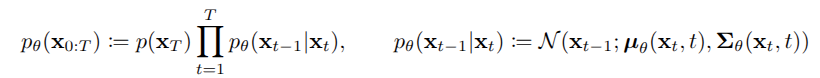
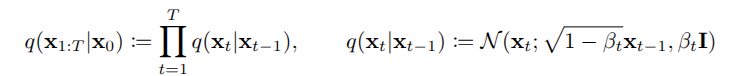
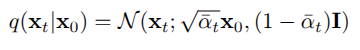
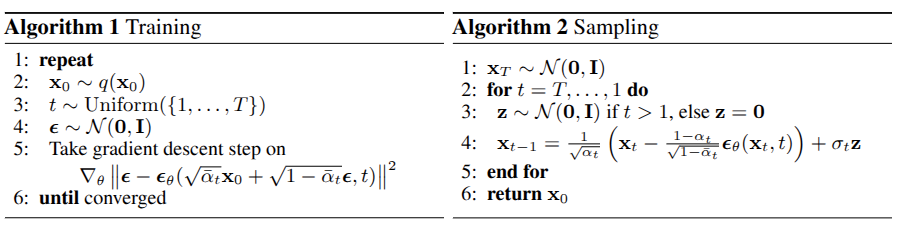

# TODO
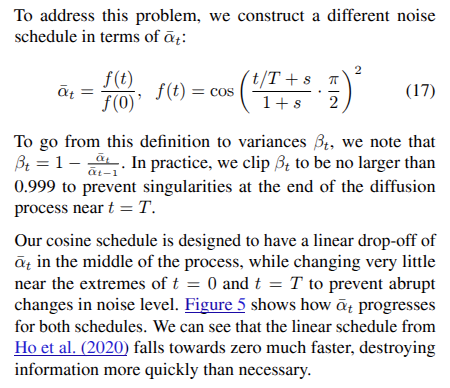

In [12]:
def gather(x: torch.Tensor, t: Union[int, torch.Tensor]):
    if isinstance(t, int):
        t = torch.tensor([t], dtype=torch.long, device=x.device)
    elif isinstance(t, list):
        t = torch.tensor(t, dtype=torch.long, device=x.device)
    elif isinstance(t, torch.Tensor):
        t = t.to(dtype=torch.long, device=x.device)
    else:
        raise ValueError("Unsupported type for t")

    temp = x.gather(0, t)
    return temp.reshape(-1, 1, 1, 1)


class BasicDiffusion:
    def __init__(
        self,
        model: nn.Module,
        device: torch.device,
        n_steps=1000,
        beta_start=1e-4,
        beta_end=0.02,
    ):
        super().__init__()
        self.n_steps = n_steps
        self.betas = torch.linspace(beta_start, beta_end, n_steps).to(device)
        self.alpha = 1.0 - self.betas
        self.alpha_cumprod = torch.cumprod(self.alpha, dim=0)

        # Compute alpha_cumprod_prev and posterior_variance
        self.alpha_cumprod_prev = torch.cat(
            [torch.ones(1, device=device), self.alpha_cumprod[:-1]]
        )
        self.posterior_variance = (
            (1.0 - self.alpha_cumprod_prev) / (1.0 - self.alpha_cumprod)
        ) * self.betas
        self.device = device
        self.model = model

    # q(xt|x0)
    def q(self, x_0, t):
        alpha_cumprod_t = gather(self.alpha_cumprod, t)
        mean = torch.sqrt(alpha_cumprod_t) * x_0
        var = 1.0 - alpha_cumprod_t
        return mean, var

    def q_sample(self, x_0, t, eps=None):
        if eps is None:
            eps = torch.randn_like(x_0)
        mean, var = self.q(x_0, t)
        return mean + torch.sqrt(var) * eps

    # p(x_t-1|x_t)
    def p_sample(self, x_t, t):
        x0_pred = self.model(x_t, t)

        alpha_bar_t = gather(self.alpha_cumprod, t)
        alpha_bar_prev_t = gather(self.alpha_cumprod_prev, t)
        alpha_t = gather(self.alpha, t)
        beta_t = gather(self.betas, t)

        mu_coef_x0 = (alpha_bar_prev_t.sqrt() * beta_t) / (1 - alpha_bar_t)
        mu_coef_xt = ((1 - alpha_bar_prev_t) * (1 - beta_t).sqrt()) / (1 - alpha_bar_t)
        # mu_coef_xt = (alpha_t.sqrt() * (1 - alpha_bar_prev_t)) / (1 - alpha_bar_t)

        mean = mu_coef_x0 * x0_pred + mu_coef_xt * x_t

        var = gather(self.posterior_variance, t)
        noise = torch.randn_like(x_t)
        mask = (t > 0).float()[:, None, None, None]
        x_t_prev = mean + torch.sqrt(var) * noise * mask

        return x_t_prev

    def loss(self, x0, noise=None):
        batch_size = x0.shape[0]
        t = torch.randint(0, self.n_steps, (batch_size,), device=x0.device).long()
        if noise is None:
            noise = torch.randn_like(x0)
        x_t = self.q_sample(x0, t, noise)
        x0_pred = self.model(x_t, t)
        return F.mse_loss(x0_pred, x0)

    def forward(self, x0, noise=None):
        return self.loss(x0, noise)

    def sample(self, n_samples=1, image_size=(1, 28, 28), xt=None):
        if xt is not None:
            x_t = xt.to(self.device)
        else:
            x_t = torch.randn(n_samples, *image_size).to(self.device)

        for t in reversed(range(self.n_steps)):
            t_batch = torch.full((n_samples,), t, device=self.device, dtype=torch.long)
            x_t = self.p_sample(x_t, t_batch)  # assumes p_sample does noise addition

        return torch.clamp(x_t, -1.0, 1.0)

# UNet
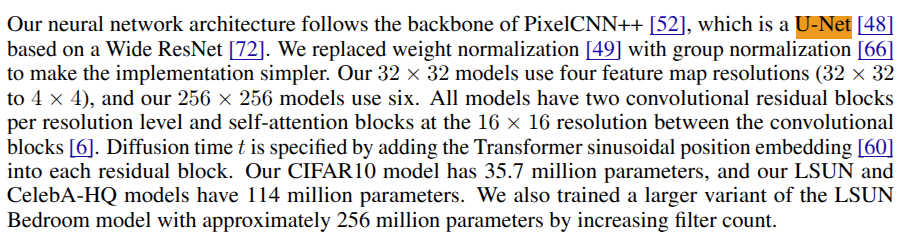
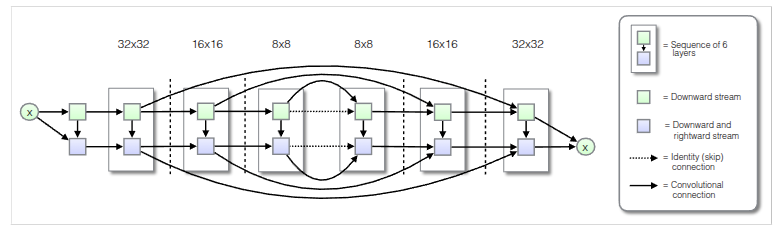

In [13]:
class SinusoidalPositionEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        device = t.device
        half_dim = self.dim // 2
        emb = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_dim, groups=8):
        super().__init__()
        self.group_norm1 = nn.GroupNorm(groups, in_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.group_norm2 = nn.GroupNorm(groups, out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.time_emb = nn.Linear(time_dim, out_channels)
        self.residual_conv = (
            nn.Conv2d(in_channels, out_channels, kernel_size=1)
            if in_channels != out_channels
            else nn.Identity()
        )

    def forward(self, x, t):
        h = self.group_norm1(x)
        h = F.silu(h)
        h = self.conv1(h)
        h = self.group_norm2(h)
        h += self.time_emb(t)[:, :, None, None]
        h = F.silu(h)
        h = self.conv2(h)
        return h + self.residual_conv(x)


class SelfAttentionBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.norm = nn.GroupNorm(8, channels)
        self.q = nn.Conv2d(channels, channels, 1)
        self.k = nn.Conv2d(channels, channels, 1)
        self.v = nn.Conv2d(channels, channels, 1)
        self.proj_out = nn.Conv2d(channels, channels, 1)

    def forward(self, x):
        B, C, H, W = x.shape
        h = self.norm(x)
        q = self.q(h).view(B, C, -1).permute(0, 2, 1)
        k = self.k(h).view(B, C, -1)
        v = self.v(h).view(B, C, -1)

        attn = torch.bmm(q, k) * (C**-0.5)
        attn = F.softmax(attn, dim=-1)

        out = torch.bmm(v, attn.permute(0, 2, 1))
        out = out.view(B, C, H, W)
        return x + self.proj_out(out)


class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, base_channels=32, time_dim=128):
        super().__init__()
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbedding(time_dim),
            nn.Linear(time_dim, time_dim * 4),
            nn.SiLU(),
            nn.Linear(time_dim * 4, time_dim),
        )

        # Downsampling
        self.down1 = nn.ModuleList(
            [
                ResidualBlock(in_channels, base_channels, time_dim, groups=1),
                ResidualBlock(base_channels, base_channels, time_dim),
            ]
        )
        self.down2 = nn.ModuleList(
            [
                ResidualBlock(base_channels, base_channels * 2, time_dim),
                SelfAttentionBlock(base_channels * 2),
                ResidualBlock(base_channels * 2, base_channels * 2, time_dim),
            ]
        )

        # Middle
        self.mid = nn.ModuleList(
            [
                ResidualBlock(base_channels * 2, base_channels * 4, time_dim),
                SelfAttentionBlock(base_channels * 4),
                ResidualBlock(base_channels * 4, base_channels * 2, time_dim),
            ]
        )

        # Upsampling
        self.up2 = nn.ModuleList(
            [
                ResidualBlock(base_channels * 4, base_channels * 2, time_dim),
                SelfAttentionBlock(base_channels * 2),
                ResidualBlock(base_channels * 2, base_channels, time_dim),
            ]
        )
        self.up1 = nn.ModuleList(
            [
                ResidualBlock(base_channels * 2, base_channels, time_dim),
                ResidualBlock(base_channels, base_channels, time_dim),
            ]
        )

        self.final_conv = nn.Conv2d(base_channels, out_channels, 3, padding=1)

        self.downsample = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode="nearest")

    def forward(self, x, t):
        t = self.time_mlp(t)
        x1 = []

        # Downsample path
        # Block 1 (28x28 -> 28x28)
        for block in self.down1:
            x = block(x, t)
        x1.append(x)
        x = self.downsample(x)  # 14x14

        # Block 2 (14x14 -> 14x14)
        for block in self.down2:
            if isinstance(block, SelfAttentionBlock):
                x = block(x)
            else:
                x = block(x, t)
        x1.append(x)
        x = self.downsample(x)  # 7x7

        # Middle (7x7 -> 7x7)
        for block in self.mid:
            if isinstance(block, SelfAttentionBlock):
                x = block(x)
            else:
                x = block(x, t)

        # Upsample path
        # Block 2 (7x7 -> 14x14)
        x = self.upsample(x)
        x = torch.cat([x, x1.pop()], dim=1)
        for block in self.up2:
            if isinstance(block, SelfAttentionBlock):
                x = block(x)
            else:
                x = block(x, t)

        # Block 1 (14x14 -> 28x28)
        x = self.upsample(x)
        x = torch.cat([x, x1.pop()], dim=1)
        for block in self.up1:
            x = block(x, t)

        return self.final_conv(x)


# model = UNet()
# x = torch.randn(8, 1, 28, 28)  # MNIST batch
# t = torch.randint(0, 1000, (8,))  # Random timesteps
# output = model(x, t)
# print(output.shape)  # Should be (8, 1, 28, 28)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.009580255..0.9992703].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.38605392..1.3538835].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7194772..1.5914325].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3066773..2.4032536].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2432079..2.5309517].


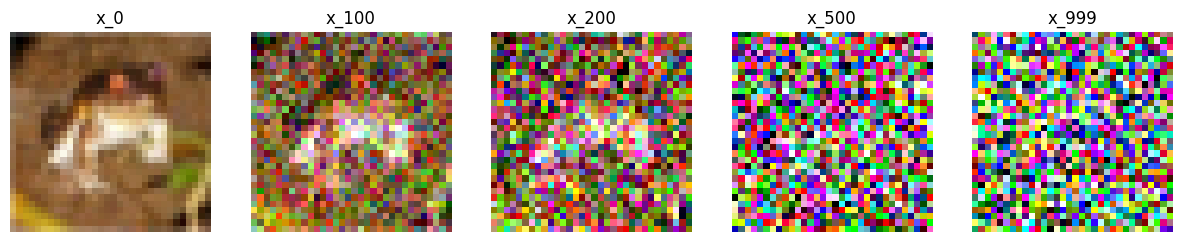

In [14]:
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
np.random.seed(42)

# Training Configuration
config = {
    "batch_size": 128,
    "epochs": 150,
    "lr": 2e-4,
    "n_steps": 1000,
    "weight_decay": 1e-5,
    "max_grad_norm": 1.0,
    "save_interval": 50,
}

# Data Preparation
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_dataset = torchvision.datasets.CIFAR10(
    root="~/ainotebook/data", train=True, download=True, transform=transform
)
dataloader = DataLoader(
    train_dataset,
    batch_size=config["batch_size"],
    shuffle=True,
    num_workers=4,
    pin_memory=True,
)

# Model Initialization
model = UNet(in_channels=3, out_channels=3, base_channels=64).to(device)
diffusion = BasicDiffusion(model, device, n_steps=config["n_steps"])
optimizer = torch.optim.AdamW(
    model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"]
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=config["epochs"]
)

img, _ = train_dataset[0]  # Get a transformed CelebA image
sampled_image = img.unsqueeze(0).to(device)  # Add batch dimension

timesteps = [0, 100, 200, 500, 999]
sampled_images = []

for t in timesteps:
    x_t = diffusion.q_sample(sampled_image, t=torch.tensor([t]).to(device))
    img = x_t.squeeze(0).cpu().permute(1, 2, 0) * 0.5 + 0.5  # Denormalize to [0,1]
    sampled_images.append(img)

# Plotting (adjust for RGB)
plt.figure(figsize=(15, 3))
for i, (t, img) in enumerate(zip(timesteps, sampled_images)):
    plt.subplot(1, len(timesteps), i + 1)
    plt.imshow(img)
    plt.title(f"x_{t}")
    plt.axis("off")
plt.show()

In [15]:
train_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
# Load the model weights
if os.path.exists("cdpm_cifar10.pth"):
    model.load_state_dict(torch.load("cdpm_cifar10.pth", map_location=device))
else:
    print("No pre-trained model found, starting training from scratch.")

dataloader = DataLoader(
    train_dataset,
    batch_size=config["batch_size"],
    shuffle=True,
    num_workers=4,
    pin_memory=True,
)

No pre-trained model found, starting training from scratch.


Epoch 1/150: 100%|██████████| 391/391 [00:13<00:00, 28.62it/s, Loss=0.1135]


Epoch 1 | Avg Loss: 0.1391


Epoch 2/150: 100%|██████████| 391/391 [00:09<00:00, 41.77it/s, Loss=0.1121]


Epoch 2 | Avg Loss: 0.1216


Epoch 3/150: 100%|██████████| 391/391 [00:09<00:00, 41.98it/s, Loss=0.1303]


Epoch 3 | Avg Loss: 0.1190


Epoch 4/150: 100%|██████████| 391/391 [00:09<00:00, 41.85it/s, Loss=0.1242]


Epoch 4 | Avg Loss: 0.1178


Epoch 5/150: 100%|██████████| 391/391 [00:18<00:00, 20.99it/s, Loss=0.1201]


Epoch 5 | Avg Loss: 0.1164


Epoch 6/150: 100%|██████████| 391/391 [00:18<00:00, 20.92it/s, Loss=0.1203]


Epoch 6 | Avg Loss: 0.1160


Epoch 7/150: 100%|██████████| 391/391 [00:18<00:00, 20.91it/s, Loss=0.1187]


Epoch 7 | Avg Loss: 0.1158


Epoch 8/150: 100%|██████████| 391/391 [00:18<00:00, 20.93it/s, Loss=0.1221]


Epoch 8 | Avg Loss: 0.1161


Epoch 9/150: 100%|██████████| 391/391 [00:18<00:00, 20.89it/s, Loss=0.1410]


Epoch 9 | Avg Loss: 0.1156


Epoch 10/150: 100%|██████████| 391/391 [00:18<00:00, 20.92it/s, Loss=0.1213]


Epoch 10 | Avg Loss: 0.1157


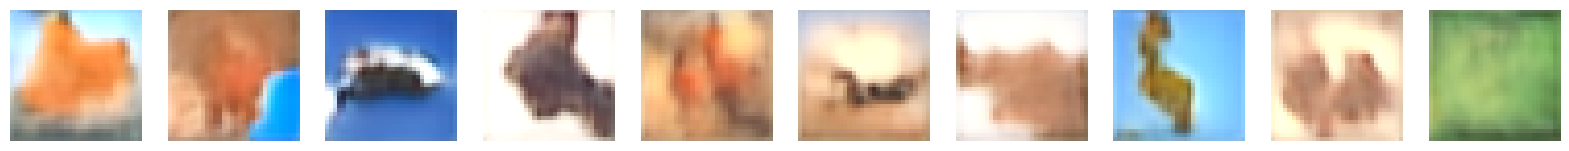

Epoch 11/150: 100%|██████████| 391/391 [00:18<00:00, 20.99it/s, Loss=0.1417]


Epoch 11 | Avg Loss: 0.1161


Epoch 12/150: 100%|██████████| 391/391 [00:18<00:00, 21.01it/s, Loss=0.1135]


Epoch 12 | Avg Loss: 0.1155


Epoch 13/150: 100%|██████████| 391/391 [00:18<00:00, 20.95it/s, Loss=0.1111]


Epoch 13 | Avg Loss: 0.1149


Epoch 14/150: 100%|██████████| 391/391 [00:18<00:00, 20.97it/s, Loss=0.1298]


Epoch 14 | Avg Loss: 0.1159


Epoch 15/150: 100%|██████████| 391/391 [00:18<00:00, 20.83it/s, Loss=0.0991]


Epoch 15 | Avg Loss: 0.1160


Epoch 16/150: 100%|██████████| 391/391 [00:18<00:00, 20.96it/s, Loss=0.1132]


Epoch 16 | Avg Loss: 0.1147


Epoch 17/150: 100%|██████████| 391/391 [00:18<00:00, 20.95it/s, Loss=0.1222]


Epoch 17 | Avg Loss: 0.1162


Epoch 18/150: 100%|██████████| 391/391 [00:18<00:00, 20.84it/s, Loss=0.1091]


Epoch 18 | Avg Loss: 0.1160


Epoch 19/150: 100%|██████████| 391/391 [00:18<00:00, 20.84it/s, Loss=0.1130]


Epoch 19 | Avg Loss: 0.1151


Epoch 20/150: 100%|██████████| 391/391 [00:18<00:00, 20.85it/s, Loss=0.1222]


Epoch 20 | Avg Loss: 0.1144


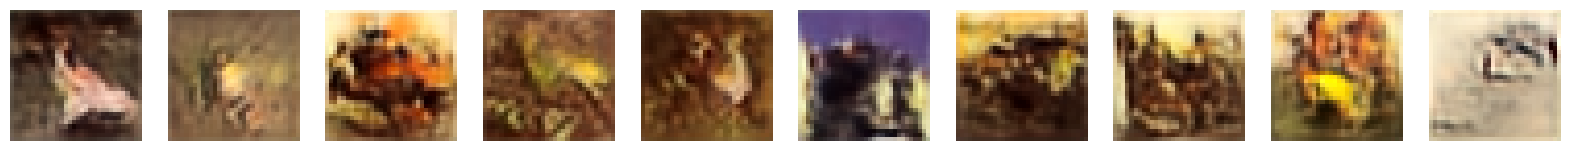

Epoch 21/150: 100%|██████████| 391/391 [00:18<00:00, 20.99it/s, Loss=0.1002]


Epoch 21 | Avg Loss: 0.1137


Epoch 22/150: 100%|██████████| 391/391 [00:18<00:00, 20.97it/s, Loss=0.1061]


Epoch 22 | Avg Loss: 0.1149


Epoch 23/150: 100%|██████████| 391/391 [00:18<00:00, 20.90it/s, Loss=0.1137]


Epoch 23 | Avg Loss: 0.1139


Epoch 24/150: 100%|██████████| 391/391 [00:18<00:00, 20.84it/s, Loss=0.1327]


Epoch 24 | Avg Loss: 0.1138


Epoch 25/150: 100%|██████████| 391/391 [00:18<00:00, 20.88it/s, Loss=0.1174]


Epoch 25 | Avg Loss: 0.1146


Epoch 26/150: 100%|██████████| 391/391 [00:18<00:00, 20.95it/s, Loss=0.1126]


Epoch 26 | Avg Loss: 0.1138


Epoch 27/150: 100%|██████████| 391/391 [00:18<00:00, 20.90it/s, Loss=0.1344]


Epoch 27 | Avg Loss: 0.1148


Epoch 28/150: 100%|██████████| 391/391 [00:18<00:00, 20.88it/s, Loss=0.1132]


Epoch 28 | Avg Loss: 0.1133


Epoch 29/150: 100%|██████████| 391/391 [00:18<00:00, 20.90it/s, Loss=0.1343]


Epoch 29 | Avg Loss: 0.1138


Epoch 30/150: 100%|██████████| 391/391 [00:18<00:00, 20.89it/s, Loss=0.1190]


Epoch 30 | Avg Loss: 0.1146


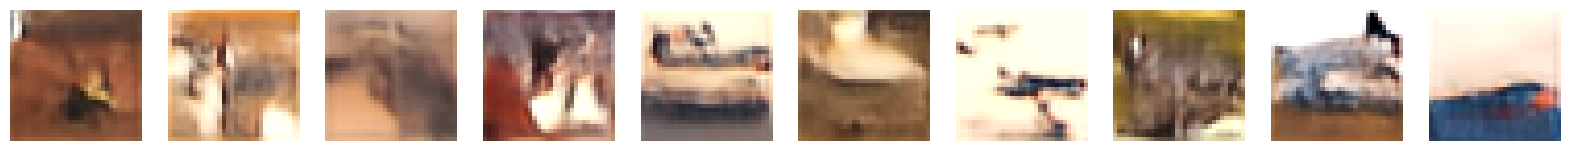

Epoch 31/150: 100%|██████████| 391/391 [00:18<00:00, 20.99it/s, Loss=0.1282]


Epoch 31 | Avg Loss: 0.1141


Epoch 32/150: 100%|██████████| 391/391 [00:18<00:00, 20.95it/s, Loss=0.1023]


Epoch 32 | Avg Loss: 0.1148


Epoch 33/150: 100%|██████████| 391/391 [00:18<00:00, 21.40it/s, Loss=0.1120]


Epoch 33 | Avg Loss: 0.1143


Epoch 34/150: 100%|██████████| 391/391 [00:18<00:00, 21.51it/s, Loss=0.1200]


Epoch 34 | Avg Loss: 0.1129


Epoch 35/150: 100%|██████████| 391/391 [00:18<00:00, 21.59it/s, Loss=0.1132]


Epoch 35 | Avg Loss: 0.1148


Epoch 36/150: 100%|██████████| 391/391 [00:18<00:00, 21.60it/s, Loss=0.1231]


Epoch 36 | Avg Loss: 0.1138


Epoch 37/150: 100%|██████████| 391/391 [00:18<00:00, 21.59it/s, Loss=0.1224]


Epoch 37 | Avg Loss: 0.1132


Epoch 38/150: 100%|██████████| 391/391 [00:18<00:00, 21.61it/s, Loss=0.1274]


Epoch 38 | Avg Loss: 0.1139


Epoch 39/150: 100%|██████████| 391/391 [00:18<00:00, 21.61it/s, Loss=0.1219]


Epoch 39 | Avg Loss: 0.1145


Epoch 40/150: 100%|██████████| 391/391 [00:18<00:00, 21.62it/s, Loss=0.1228]


Epoch 40 | Avg Loss: 0.1140


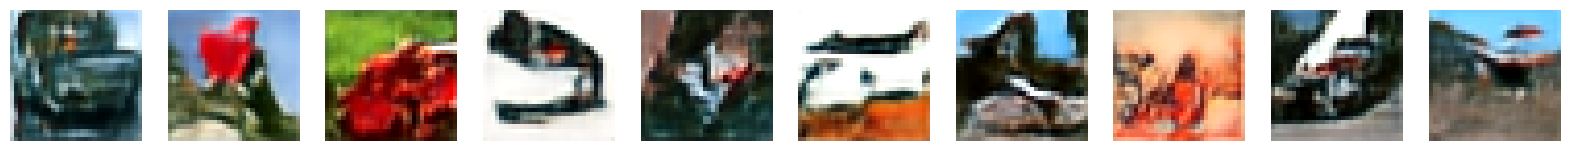

Epoch 41/150: 100%|██████████| 391/391 [00:18<00:00, 21.33it/s, Loss=0.1140]


Epoch 41 | Avg Loss: 0.1138


Epoch 42/150: 100%|██████████| 391/391 [00:18<00:00, 21.61it/s, Loss=0.1174]


Epoch 42 | Avg Loss: 0.1141


Epoch 43/150: 100%|██████████| 391/391 [00:18<00:00, 21.62it/s, Loss=0.0900]


Epoch 43 | Avg Loss: 0.1137


Epoch 44/150: 100%|██████████| 391/391 [00:18<00:00, 21.62it/s, Loss=0.1007]


Epoch 44 | Avg Loss: 0.1142


Epoch 45/150: 100%|██████████| 391/391 [00:18<00:00, 21.60it/s, Loss=0.1083]


Epoch 45 | Avg Loss: 0.1137


Epoch 46/150: 100%|██████████| 391/391 [00:18<00:00, 21.60it/s, Loss=0.1144]


Epoch 46 | Avg Loss: 0.1139


Epoch 47/150: 100%|██████████| 391/391 [00:18<00:00, 21.59it/s, Loss=0.1081]


Epoch 47 | Avg Loss: 0.1133


Epoch 48/150: 100%|██████████| 391/391 [00:18<00:00, 21.60it/s, Loss=0.1178]


Epoch 48 | Avg Loss: 0.1131


Epoch 49/150: 100%|██████████| 391/391 [00:18<00:00, 21.61it/s, Loss=0.1133]


Epoch 49 | Avg Loss: 0.1140


Epoch 50/150: 100%|██████████| 391/391 [00:18<00:00, 21.62it/s, Loss=0.1125]


Epoch 50 | Avg Loss: 0.1138


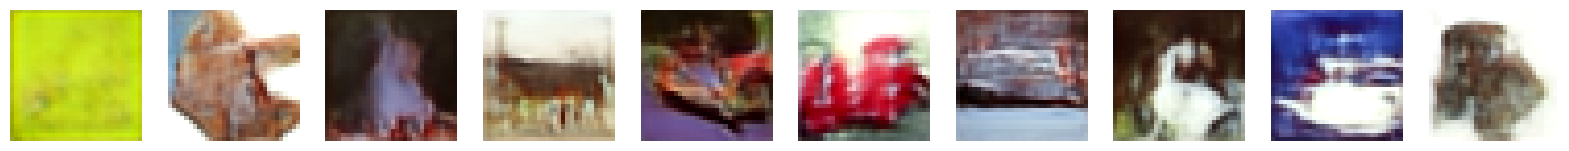

Epoch 51/150: 100%|██████████| 391/391 [00:18<00:00, 21.60it/s, Loss=0.1065]


Epoch 51 | Avg Loss: 0.1132


Epoch 52/150: 100%|██████████| 391/391 [00:18<00:00, 21.17it/s, Loss=0.1156]


Epoch 52 | Avg Loss: 0.1136


Epoch 53/150: 100%|██████████| 391/391 [00:18<00:00, 20.98it/s, Loss=0.1049]


Epoch 53 | Avg Loss: 0.1129


Epoch 54/150: 100%|██████████| 391/391 [00:18<00:00, 21.00it/s, Loss=0.1310]


Epoch 54 | Avg Loss: 0.1137


Epoch 55/150: 100%|██████████| 391/391 [00:18<00:00, 20.99it/s, Loss=0.1188]


Epoch 55 | Avg Loss: 0.1135


Epoch 56/150: 100%|██████████| 391/391 [00:18<00:00, 20.92it/s, Loss=0.0973]


Epoch 56 | Avg Loss: 0.1135


Epoch 57/150: 100%|██████████| 391/391 [00:18<00:00, 20.91it/s, Loss=0.1283]


Epoch 57 | Avg Loss: 0.1134


Epoch 58/150: 100%|██████████| 391/391 [00:18<00:00, 21.01it/s, Loss=0.0949]


Epoch 58 | Avg Loss: 0.1130


Epoch 59/150: 100%|██████████| 391/391 [00:18<00:00, 21.01it/s, Loss=0.0934]


Epoch 59 | Avg Loss: 0.1131


Epoch 60/150: 100%|██████████| 391/391 [00:18<00:00, 20.92it/s, Loss=0.1246]


Epoch 60 | Avg Loss: 0.1136


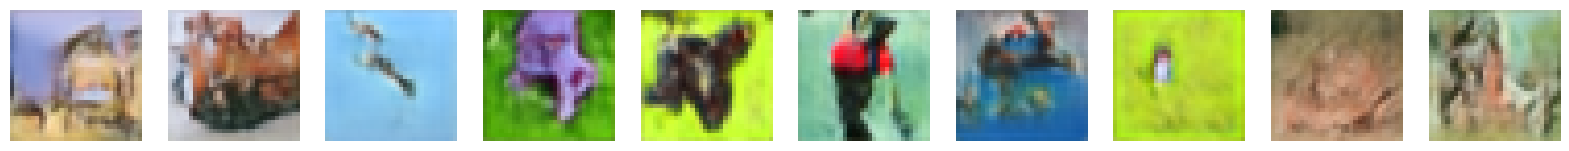

Epoch 61/150: 100%|██████████| 391/391 [00:18<00:00, 20.91it/s, Loss=0.1169]


Epoch 61 | Avg Loss: 0.1128


Epoch 62/150: 100%|██████████| 391/391 [00:18<00:00, 20.95it/s, Loss=0.1177]


Epoch 62 | Avg Loss: 0.1126


Epoch 63/150: 100%|██████████| 391/391 [00:18<00:00, 21.03it/s, Loss=0.1297]


Epoch 63 | Avg Loss: 0.1121


Epoch 64/150: 100%|██████████| 391/391 [00:18<00:00, 20.93it/s, Loss=0.1207]


Epoch 64 | Avg Loss: 0.1136


Epoch 65/150: 100%|██████████| 391/391 [00:18<00:00, 20.93it/s, Loss=0.1127]


Epoch 65 | Avg Loss: 0.1127


Epoch 66/150: 100%|██████████| 391/391 [00:18<00:00, 21.02it/s, Loss=0.1045]


Epoch 66 | Avg Loss: 0.1132


Epoch 67/150: 100%|██████████| 391/391 [00:18<00:00, 21.02it/s, Loss=0.0997]


Epoch 67 | Avg Loss: 0.1129


Epoch 68/150: 100%|██████████| 391/391 [00:18<00:00, 21.02it/s, Loss=0.1169]


Epoch 68 | Avg Loss: 0.1130


Epoch 69/150: 100%|██████████| 391/391 [00:18<00:00, 21.04it/s, Loss=0.0996]


Epoch 69 | Avg Loss: 0.1128


Epoch 70/150: 100%|██████████| 391/391 [00:18<00:00, 21.00it/s, Loss=0.1015]


Epoch 70 | Avg Loss: 0.1126


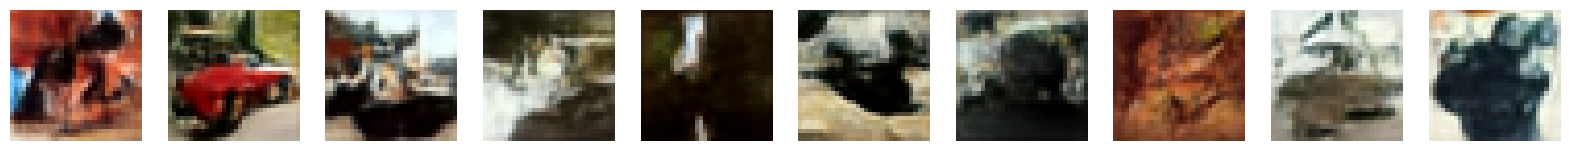

Epoch 71/150: 100%|██████████| 391/391 [00:18<00:00, 20.96it/s, Loss=0.1114]


Epoch 71 | Avg Loss: 0.1132


Epoch 72/150: 100%|██████████| 391/391 [00:18<00:00, 20.90it/s, Loss=0.1249]


Epoch 72 | Avg Loss: 0.1135


Epoch 73/150: 100%|██████████| 391/391 [00:18<00:00, 20.93it/s, Loss=0.1151]


Epoch 73 | Avg Loss: 0.1129


Epoch 74/150: 100%|██████████| 391/391 [00:18<00:00, 20.93it/s, Loss=0.1243]


Epoch 74 | Avg Loss: 0.1129


Epoch 75/150: 100%|██████████| 391/391 [00:18<00:00, 21.00it/s, Loss=0.1165]


Epoch 75 | Avg Loss: 0.1131


Epoch 76/150: 100%|██████████| 391/391 [00:18<00:00, 21.00it/s, Loss=0.1420]


Epoch 76 | Avg Loss: 0.1127


Epoch 77/150: 100%|██████████| 391/391 [00:18<00:00, 20.92it/s, Loss=0.0981]


Epoch 77 | Avg Loss: 0.1131


Epoch 78/150: 100%|██████████| 391/391 [00:18<00:00, 20.97it/s, Loss=0.1220]


Epoch 78 | Avg Loss: 0.1139


Epoch 79/150: 100%|██████████| 391/391 [00:18<00:00, 21.02it/s, Loss=0.1097]


Epoch 79 | Avg Loss: 0.1134


Epoch 80/150: 100%|██████████| 391/391 [00:18<00:00, 21.02it/s, Loss=0.0965]


Epoch 80 | Avg Loss: 0.1134


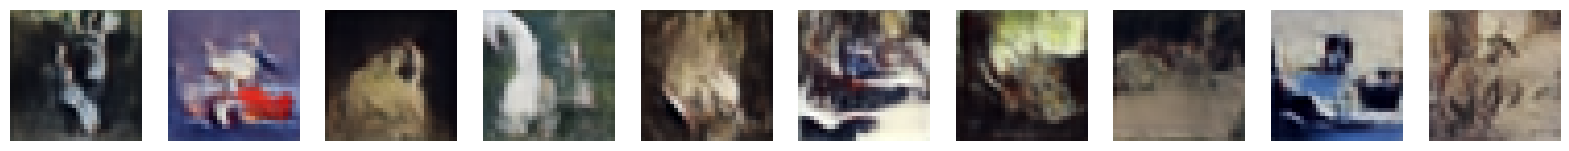

Epoch 81/150: 100%|██████████| 391/391 [00:18<00:00, 20.98it/s, Loss=0.1066]


Epoch 81 | Avg Loss: 0.1135


Epoch 82/150: 100%|██████████| 391/391 [00:18<00:00, 20.89it/s, Loss=0.1162]


Epoch 82 | Avg Loss: 0.1132


Epoch 83/150: 100%|██████████| 391/391 [00:18<00:00, 20.95it/s, Loss=0.1191]


Epoch 83 | Avg Loss: 0.1130


Epoch 84/150: 100%|██████████| 391/391 [00:18<00:00, 20.97it/s, Loss=0.1265]


Epoch 84 | Avg Loss: 0.1128


Epoch 85/150: 100%|██████████| 391/391 [00:18<00:00, 20.89it/s, Loss=0.1207]


Epoch 85 | Avg Loss: 0.1133


Epoch 86/150: 100%|██████████| 391/391 [00:18<00:00, 20.87it/s, Loss=0.1059]


Epoch 86 | Avg Loss: 0.1130


Epoch 87/150: 100%|██████████| 391/391 [00:18<00:00, 20.88it/s, Loss=0.1241]


Epoch 87 | Avg Loss: 0.1132


Epoch 88/150: 100%|██████████| 391/391 [00:18<00:00, 20.92it/s, Loss=0.1002]


Epoch 88 | Avg Loss: 0.1130


Epoch 89/150: 100%|██████████| 391/391 [00:18<00:00, 20.99it/s, Loss=0.1439]


Epoch 89 | Avg Loss: 0.1124


Epoch 90/150: 100%|██████████| 391/391 [00:18<00:00, 20.98it/s, Loss=0.0992]


Epoch 90 | Avg Loss: 0.1130


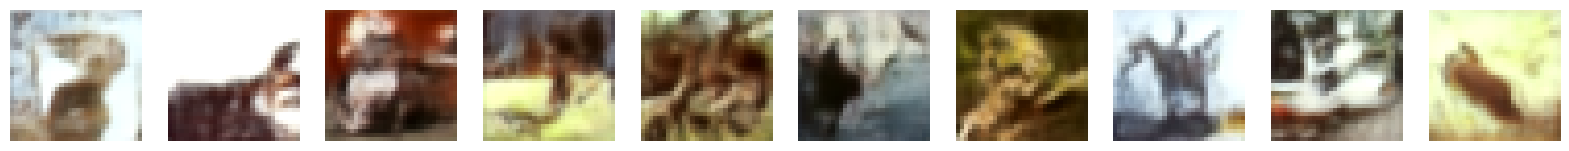

Epoch 91/150: 100%|██████████| 391/391 [00:18<00:00, 20.95it/s, Loss=0.1116]


Epoch 91 | Avg Loss: 0.1131


Epoch 92/150: 100%|██████████| 391/391 [00:18<00:00, 20.92it/s, Loss=0.1202]


Epoch 92 | Avg Loss: 0.1123


Epoch 93/150: 100%|██████████| 391/391 [00:18<00:00, 20.97it/s, Loss=0.1077]


Epoch 93 | Avg Loss: 0.1126


Epoch 94/150: 100%|██████████| 391/391 [00:18<00:00, 20.85it/s, Loss=0.0855]


Epoch 94 | Avg Loss: 0.1128


Epoch 95/150: 100%|██████████| 391/391 [00:18<00:00, 20.94it/s, Loss=0.1004]


Epoch 95 | Avg Loss: 0.1130


Epoch 96/150: 100%|██████████| 391/391 [00:18<00:00, 20.90it/s, Loss=0.1008]


Epoch 96 | Avg Loss: 0.1129


Epoch 97/150: 100%|██████████| 391/391 [00:18<00:00, 20.93it/s, Loss=0.1117]


Epoch 97 | Avg Loss: 0.1115


Epoch 98/150: 100%|██████████| 391/391 [00:18<00:00, 20.97it/s, Loss=0.1004]


Epoch 98 | Avg Loss: 0.1132


Epoch 99/150: 100%|██████████| 391/391 [00:18<00:00, 20.98it/s, Loss=0.1106]


Epoch 99 | Avg Loss: 0.1135


Epoch 100/150: 100%|██████████| 391/391 [00:18<00:00, 20.91it/s, Loss=0.1054]


Epoch 100 | Avg Loss: 0.1127


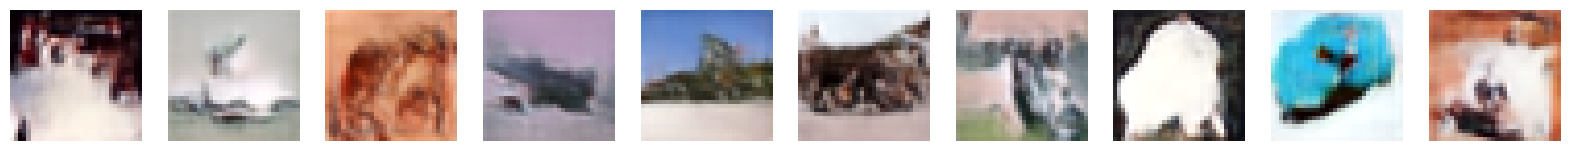

Epoch 101/150: 100%|██████████| 391/391 [00:18<00:00, 20.90it/s, Loss=0.0999]


Epoch 101 | Avg Loss: 0.1120


Epoch 102/150: 100%|██████████| 391/391 [00:18<00:00, 20.89it/s, Loss=0.0931]


Epoch 102 | Avg Loss: 0.1121


Epoch 103/150: 100%|██████████| 391/391 [00:18<00:00, 20.94it/s, Loss=0.1133]


Epoch 103 | Avg Loss: 0.1127


Epoch 104/150: 100%|██████████| 391/391 [00:18<00:00, 20.82it/s, Loss=0.1063]


Epoch 104 | Avg Loss: 0.1119


Epoch 105/150: 100%|██████████| 391/391 [00:18<00:00, 20.97it/s, Loss=0.1177]


Epoch 105 | Avg Loss: 0.1123


Epoch 106/150: 100%|██████████| 391/391 [00:18<00:00, 20.99it/s, Loss=0.1066]


Epoch 106 | Avg Loss: 0.1121


Epoch 107/150: 100%|██████████| 391/391 [00:18<00:00, 20.91it/s, Loss=0.0954]


Epoch 107 | Avg Loss: 0.1128


Epoch 108/150: 100%|██████████| 391/391 [00:18<00:00, 20.92it/s, Loss=0.1148]


Epoch 108 | Avg Loss: 0.1118


Epoch 109/150: 100%|██████████| 391/391 [00:18<00:00, 20.91it/s, Loss=0.0975]


Epoch 109 | Avg Loss: 0.1120


Epoch 110/150: 100%|██████████| 391/391 [00:18<00:00, 20.91it/s, Loss=0.1035]


Epoch 110 | Avg Loss: 0.1126


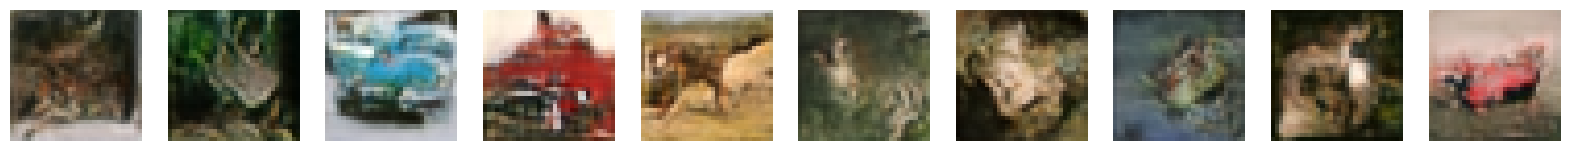

Epoch 111/150: 100%|██████████| 391/391 [00:18<00:00, 20.92it/s, Loss=0.1118]


Epoch 111 | Avg Loss: 0.1125


Epoch 112/150: 100%|██████████| 391/391 [00:18<00:00, 20.91it/s, Loss=0.1075]


Epoch 112 | Avg Loss: 0.1129


Epoch 113/150: 100%|██████████| 391/391 [00:18<00:00, 21.00it/s, Loss=0.1120]


Epoch 113 | Avg Loss: 0.1123


Epoch 114/150: 100%|██████████| 391/391 [00:18<00:00, 20.90it/s, Loss=0.1073]


Epoch 114 | Avg Loss: 0.1121


Epoch 115/150: 100%|██████████| 391/391 [00:18<00:00, 20.85it/s, Loss=0.0965]


Epoch 115 | Avg Loss: 0.1127


Epoch 116/150: 100%|██████████| 391/391 [00:18<00:00, 20.84it/s, Loss=0.1107]


Epoch 116 | Avg Loss: 0.1114


Epoch 117/150: 100%|██████████| 391/391 [00:18<00:00, 20.87it/s, Loss=0.1215]


Epoch 117 | Avg Loss: 0.1127


Epoch 118/150: 100%|██████████| 391/391 [00:18<00:00, 20.88it/s, Loss=0.0927]


Epoch 118 | Avg Loss: 0.1121


Epoch 119/150: 100%|██████████| 391/391 [00:18<00:00, 20.87it/s, Loss=0.1347]


Epoch 119 | Avg Loss: 0.1117


Epoch 120/150: 100%|██████████| 391/391 [00:18<00:00, 20.97it/s, Loss=0.1117]


Epoch 120 | Avg Loss: 0.1123


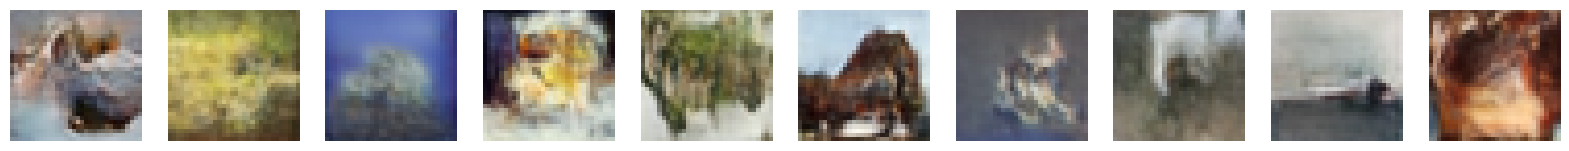

Epoch 121/150: 100%|██████████| 391/391 [00:18<00:00, 20.99it/s, Loss=0.1221]


Epoch 121 | Avg Loss: 0.1123


Epoch 122/150: 100%|██████████| 391/391 [00:18<00:00, 20.99it/s, Loss=0.1144]


Epoch 122 | Avg Loss: 0.1123


Epoch 123/150: 100%|██████████| 391/391 [00:18<00:00, 21.00it/s, Loss=0.1136]


Epoch 123 | Avg Loss: 0.1125


Epoch 124/150: 100%|██████████| 391/391 [00:18<00:00, 20.80it/s, Loss=0.0853]


Epoch 124 | Avg Loss: 0.1120


Epoch 125/150: 100%|██████████| 391/391 [00:18<00:00, 20.89it/s, Loss=0.1146]


Epoch 125 | Avg Loss: 0.1127


Epoch 126/150: 100%|██████████| 391/391 [00:18<00:00, 20.88it/s, Loss=0.1001]


Epoch 126 | Avg Loss: 0.1124


Epoch 127/150: 100%|██████████| 391/391 [00:18<00:00, 20.97it/s, Loss=0.1085]


Epoch 127 | Avg Loss: 0.1118


Epoch 128/150: 100%|██████████| 391/391 [00:18<00:00, 21.00it/s, Loss=0.1160]


Epoch 128 | Avg Loss: 0.1123


Epoch 129/150: 100%|██████████| 391/391 [00:18<00:00, 20.93it/s, Loss=0.1113]


Epoch 129 | Avg Loss: 0.1124


Epoch 130/150: 100%|██████████| 391/391 [00:18<00:00, 20.90it/s, Loss=0.1083]


Epoch 130 | Avg Loss: 0.1120


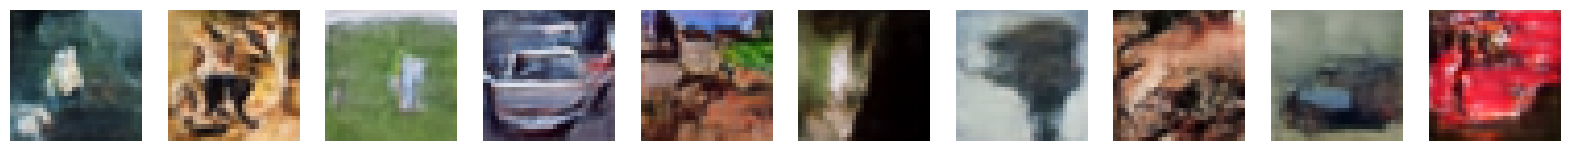

Epoch 131/150: 100%|██████████| 391/391 [00:18<00:00, 20.91it/s, Loss=0.1098]


Epoch 131 | Avg Loss: 0.1120


Epoch 132/150: 100%|██████████| 391/391 [00:18<00:00, 20.97it/s, Loss=0.1249]


Epoch 132 | Avg Loss: 0.1121


Epoch 133/150: 100%|██████████| 391/391 [00:18<00:00, 21.00it/s, Loss=0.0961]


Epoch 133 | Avg Loss: 0.1116


Epoch 134/150: 100%|██████████| 391/391 [00:18<00:00, 20.83it/s, Loss=0.1272]


Epoch 134 | Avg Loss: 0.1119


Epoch 135/150: 100%|██████████| 391/391 [00:18<00:00, 21.02it/s, Loss=0.1149]


Epoch 135 | Avg Loss: 0.1124


Epoch 136/150: 100%|██████████| 391/391 [00:18<00:00, 20.98it/s, Loss=0.0936]


Epoch 136 | Avg Loss: 0.1115


Epoch 137/150: 100%|██████████| 391/391 [00:18<00:00, 20.92it/s, Loss=0.1147]


Epoch 137 | Avg Loss: 0.1130


Epoch 138/150: 100%|██████████| 391/391 [00:18<00:00, 21.01it/s, Loss=0.0987]


Epoch 138 | Avg Loss: 0.1123


Epoch 139/150: 100%|██████████| 391/391 [00:18<00:00, 20.91it/s, Loss=0.1040]


Epoch 139 | Avg Loss: 0.1121


Epoch 140/150: 100%|██████████| 391/391 [00:18<00:00, 21.00it/s, Loss=0.1225]


Epoch 140 | Avg Loss: 0.1114


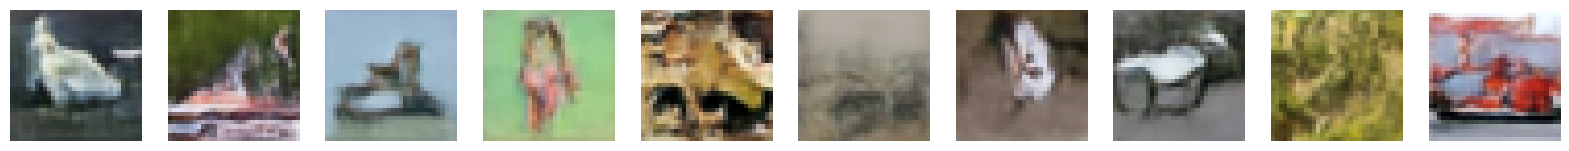

Epoch 141/150: 100%|██████████| 391/391 [00:18<00:00, 20.99it/s, Loss=0.1243]


Epoch 141 | Avg Loss: 0.1124


Epoch 142/150: 100%|██████████| 391/391 [00:18<00:00, 20.97it/s, Loss=0.1263]


Epoch 142 | Avg Loss: 0.1114


Epoch 143/150: 100%|██████████| 391/391 [00:18<00:00, 20.96it/s, Loss=0.1079]


Epoch 143 | Avg Loss: 0.1115


Epoch 144/150: 100%|██████████| 391/391 [00:18<00:00, 20.91it/s, Loss=0.0843]


Epoch 144 | Avg Loss: 0.1121


Epoch 145/150: 100%|██████████| 391/391 [00:18<00:00, 20.99it/s, Loss=0.1170]


Epoch 145 | Avg Loss: 0.1124


Epoch 146/150: 100%|██████████| 391/391 [00:18<00:00, 20.88it/s, Loss=0.1096]


Epoch 146 | Avg Loss: 0.1124


Epoch 147/150: 100%|██████████| 391/391 [00:18<00:00, 21.03it/s, Loss=0.1064]


Epoch 147 | Avg Loss: 0.1120


Epoch 148/150: 100%|██████████| 391/391 [00:18<00:00, 21.01it/s, Loss=0.1191]


Epoch 148 | Avg Loss: 0.1127


Epoch 149/150: 100%|██████████| 391/391 [00:18<00:00, 20.96it/s, Loss=0.1185]


Epoch 149 | Avg Loss: 0.1123


Epoch 150/150: 100%|██████████| 391/391 [00:18<00:00, 21.01it/s, Loss=0.0976]


Epoch 150 | Avg Loss: 0.1121


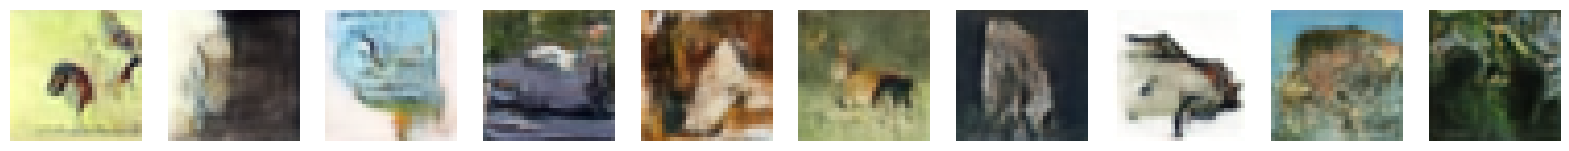

Training completed!


In [16]:
best_loss = float("inf")
for epoch in range(config["epochs"]):
    model.train()
    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{config['epochs']}")
    total_loss = 0

    for images, _ in pbar:
        images = images.to(device)
        optimizer.zero_grad()
        loss = diffusion.loss(images)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), config["max_grad_norm"])
        optimizer.step()
        total_loss += loss.item()
        pbar.set_postfix({"Loss": f"{loss.item():.4f}"})

    scheduler.step()
    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1} | Avg Loss: {avg_loss:.4f}")

    # Sampling and Saving
    if (epoch + 1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            sampled_images = diffusion.sample(n_samples=10, image_size=(3, 32, 32))
            sampled_images = torch.clamp(sampled_images, -1.0, 1.0)
            plt.figure(figsize=(20, 4))
            for i in range(10):
                plt.subplot(1, 10, i + 1)
                img = sampled_images[i].cpu().permute(1, 2, 0).numpy()
                img = (img * 0.5 + 0.5).clip(0, 1)
                plt.imshow(img)
                plt.axis("off")
            plt.show()

torch.save(model.state_dict(), "cdpm_cifar10_final.pth")
print("Training completed!")